<a href="https://colab.research.google.com/github/liuxx479/NGphotoz/blob/master/prep_mass_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *
from scipy.stats import norm
from scipy.stats import uniform
from astropy.io import fits
from astropy import units as u
import os
sys.modules["mpi4py"] = None
from lenstools import ConvergenceMap
from IPython.display import Image
%matplotlib inline

/global/homes/j/jialiu/.local/cori/3.7-anaconda-2019.10/lib/python3.7/site-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)


### goals of this notebook
##### 1) compute the nubmer density per z bin, using the fiducial photo-z (sigma_z=0, or step function was used)
##### 2) add noise as GRF to each redshift
##### 3) smooth the maps
##### 4) define the bin edges
##### 5) compute peaks, minima, PDF, MFs, moments
##### 6) turn this into a python code

In [61]:
#!git add prep_map_stats.ipynb; git commit -m 'update prep_map_stats.ipynb; update plot label'; git push
#!git add ngal_tomo.txt; git commit -m 'add ngal_tomo.txt'; git push
#!git add map_stats.py; git commit -m 'add map_stats.py'; git push

[master 1c9ed28] add map_stats.py
 1 file changed, 102 insertions(+)
 create mode 100644 map_stats.py
Counting objects: 3, done.
Delta compression using up to 64 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.78 KiB | 1.78 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To ssh://github.com/liuxx479/NGphotoz.git
   b1a9f97..1c9ed28  master -> master


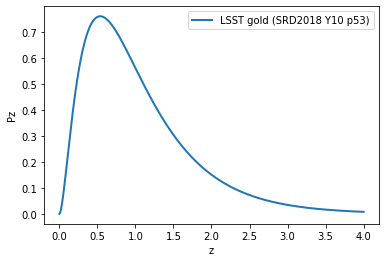

In [4]:
##### number density per redshift bins
def Pz_norm(zp_support, pz):
  return pz/np.trapz(pz, zp_support)

def Pz_norm_tomo(zp_support, pz):
  return array([Pz_norm(zp_support, ipz) for ipz in pz])

zarr=np.linspace(0,4, 501)
delta_z=0.5

tomo_centers=np.arange(0.5, 3, delta_z)
tomo_widths=np.ones(5)*delta_z
tomo_edges = np.array([tomo_centers-delta_z/2, tomo_centers+delta_z/2]).T

z0_SRD, alpha_SRD = 0.11, 0.68
Pz_SRD_unnorm = lambda z: z**2 * exp(-(z/z0_SRD)**alpha_SRD)
Pz_SRD_norm = lambda z: Pz_norm(z, Pz_SRD_unnorm(z))

plot(zarr, Pz_SRD_norm(zarr), lw=2, label='LSST gold (SRD2018 Y10 p53)')
xlabel('z')
ylabel('Pz')
legend()
show()

In [5]:
############ fiducial model: pz_true.txt 
### zbias=0, sigma_z=0, outlier=0; it should have sharp cut off at the bin edges ([0.25, 0.75], [0.75, 1.25]...)
####### LSST SRD Y10 numbers page 53
######## SRD: https://arxiv.org/abs/1809.01669
## neff: (z0, α) = (0.13, 0.78) for Y1 and (0.11, 0.68) for Y10
## neff = 10 and 27 arcmin−2 as the lensing neff in Y1 and Y10
## however, according to the original Chang 2013 paper, unmasked neff=37
sigma_e = 0.26 ## per component, do I need a sqrt(2) to get both components? (I didn't do this in 2014..)
neff = 37 ## chang+2013 n=46, for fiducial case
ngal = 46

### 1) compute the nubmer density per z bin

In [6]:
ngal_tomo = np.zeros(5)
Pz_norm_factor = np.trapz(Pz_SRD_unnorm(zarr),zarr)
print (Pz_norm_factor)

for i in range(5):
    iz0,iz1=tomo_edges[i]
    izarr=zarr[where((zarr>iz0)&(zarr<iz1))]
    ngal_tomo[i]= ngal * np.trapz(Pz_SRD_unnorm(izarr), izarr) / Pz_norm_factor

0.020049679068572506


In [7]:
print ('number of galaxies per redshift bin \n(ngal=%i, %s galaxies in 5 bins):'%(ngal, sum(ngal_tomo)))
for i in range(5):
    print ('z=%s, ngal=%.2f /arcmin^2'%(tomo_edges[i], ngal_tomo[i]))

number of galaxies per redshift bin 
(ngal=46, 40.99631314209885 galaxies in 5 bins):
z=[0.25 0.75], ngal=16.07 /arcmin^2
z=[0.75 1.25], ngal=12.82 /arcmin^2
z=[1.25 1.75], ngal=6.93 /arcmin^2
z=[1.75 2.25], ngal=3.51 /arcmin^2
z=[2.25 2.75], ngal=1.66 /arcmin^2


### 2) add noise as GRF to each redshift

In [8]:
###### get a set of 5 test maps
#test_dir = '/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/06_f/'
# std: [0.007314169, 0.019146424, 0.031151935, 0.041499652, 0.050280314]

##### change to fiducial model, so I can get the std for the maps
test_dir = '/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/fid_f/'
os.listdir(test_dir)[:10]
fnames = [test_dir+'kappa_LSST-SRD_tomo%i_cone1.fits'%(i) for i in range(1,6)]
test_maps = array([fits.open(ifn)[0].data for ifn in fnames])
istds = [std(it) for it in test_maps]
print (istds)

[0.008729362, 0.020171303, 0.03156849, 0.041291032, 0.049576506]


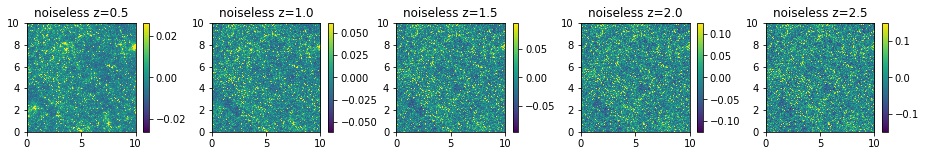

In [9]:
#### plot original kappa maps
figure(figsize=(16,2))
for i in range(5):
    subplot(1,5,i+1)
    istd=istds[i]
    imshow(test_maps[i], vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10])
    title('noiseless z=%.1f'%(tomo_centers[i]))
    colorbar()

In [10]:
### white noise maps for shape noise
map_side_deg = 10*u.degree
pixel_angular_side = map_side_deg / test_maps[0].shape[0]

sigma_pix_arr =[ (sigma_e / (pixel_angular_side * sqrt(ingal / u.arcmin**2))).decompose().value
                for ingal in ngal_tomo]

print (map_side_deg, test_maps[0].shape[0])
print (pixel_angular_side.to (u.arcmin))
print (sigma_pix_arr)

np.random.seed(2)
noise_maps = [np.random.normal(loc=0.0, scale=sigma_pix_arr[i], size=test_maps[0].shape) 
              for i in range(5)]

# #Generate shape noise
#sigma = ((0.15 + 0.035*z) / (pixel_angular_side * np.sqrt(ngal))).decompose().value
# np.random.seed(seed)
# noise_map = np.random.normal(loc=0.0,scale=sigma,size=self.shape) 

10.0 deg 7745
0.0774693350548741 arcmin
[0.8373384105463355, 0.9372762624156529, 1.274722171595974, 1.7907843269067931, 2.6010219215711436]


In [11]:
## turn it into convergencemap instance
conv_noiseless_maps = [ConvergenceMap(data=test_maps[i], angle=map_side_deg) for i in range(5)]
conv_maps = [ConvergenceMap(data=test_maps[i]+noise_maps[i], angle=map_side_deg) for i in range(5)]

In [12]:
istds_noisy = [conv_maps[i].std() for i in range(5)]
print (istds_noisy)

[0.8372144910475636, 0.9374448167340826, 1.275036492930593, 1.791285774123251, 2.6011273223545293]


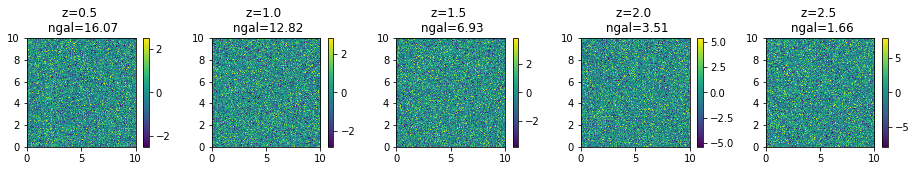

In [13]:
figure(figsize=(16,2))
for i in range(5):
    subplot(1,5,i+1)
    istd=istds_noisy[i]
    imshow(conv_maps[i].data, vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10])
    title('z=%.1f \n ngal=%.2f'%(tomo_centers[i], ngal_tomo[i]))
    colorbar()

### 3) smooth the maps

In [14]:
theta_g = 5 #arcmin
smoothed_conv_maps= [conv_maps[i].smooth(theta_g*u.arcmin) for i in range(5)]

In [15]:
istds_smoothed = [smoothed_conv_maps[i].std() for i in range(5)]
print (istds_smoothed)

[0.005429373583228638, 0.008246646050356712, 0.011305704878883282, 0.014372960836719914, 0.017822610121800975]


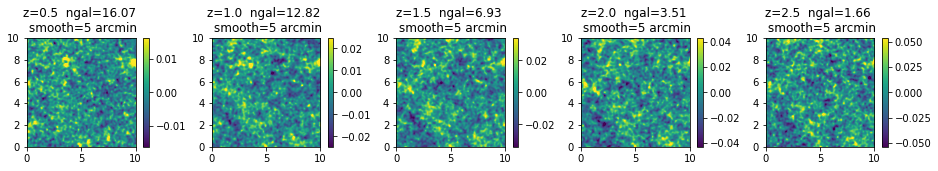

In [16]:
figure(figsize=(16,2))
for i in range(5):
    subplot(1,5,i+1)
    istd=istds_smoothed[i]
    imshow(smoothed_conv_maps[i].data, vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10])
    title('z=%.1f  ngal=%.2f \n smooth=%s arcmin'%(tomo_centers[i], ngal_tomo[i], theta_g))
    colorbar()

### 4) define the bin edges

<img src="theory_noise_smoothed.jpg" width="400">

In [17]:
######### the std of noise maps
istds_noise_smoothed = array([ConvergenceMap(data=noise_maps[i], 
                                             angle=map_side_deg).smooth(theta_g*u.arcmin,mode='wrap').std() 
                            for i in range(5)])

In [18]:
# this is from Coulton2019, not sure where is the log(2) factor from
# const_n = 1/sqrt(4*log(2)*pi)#0.3388303758015525 

# this matches yang2011, with their 1 arcmin = my/usual 1/sqrt(2) arcmin, and seem correct
const_n = 1/sqrt(4*pi)

## theta_g in unit of 1 arcmin, ngal in unit of 1/armin^2
sigma_smooth = lambda ngal, theta_g: const_n* sigma_e/(theta_g * sqrt(ngal))
sigma_n_theory = sigma_smooth (array(ngal_tomo), theta_g)

print ('std for smoothed maps:')
print (array(istds_smoothed), 'sim (white noise+kappa)')
print (istds_noise_smoothed, 'sim (white noise)')
print (sigma_n_theory, 'theory (white noise)')
print (sigma_n_theory/istds_noise_smoothed, 'theory/sim')

std for smoothed maps:
[0.00542937 0.00824665 0.0113057  0.01437296 0.01782261] sim (white noise+kappa)
[0.00367996 0.0041307  0.00571327 0.00767741 0.01108711] sim (white noise)
[0.00365979 0.00409659 0.00557148 0.00782705 0.01136839] theory (white noise)
[0.99451827 0.99174296 0.97518189 1.01949161 1.0253702 ] theory/sim


In [52]:
### make sure smoothing is not done in place - pass
test_map = ConvergenceMap(data=rand(4,4), angle=4*u.arcmin)
print (test_map.data)
smoothed_test_maps = test_map.smooth(1*u.arcmin)
print (smoothed_test_maps.data)
print (test_map.data)

[[ 0.18605  0.42806  0.55192  0.83699]
 [ 0.84367  0.61031  0.84704  0.49342]
 [ 0.19476  0.43832  0.80993  0.64806]
 [ 0.45831  0.69043  0.64575  0.30849]]
[[ 0.42997  0.50915  0.61729  0.68646]
 [ 0.50062  0.56374  0.63533  0.64975]
 [ 0.48577  0.56397  0.61818  0.59192]
 [ 0.48107  0.56047  0.58083  0.51701]]
[[ 0.18605  0.42806  0.55192  0.83699]
 [ 0.84367  0.61031  0.84704  0.49342]
 [ 0.19476  0.43832  0.80993  0.64806]
 [ 0.45831  0.69043  0.64575  0.30849]]


In [23]:
sigma_bin_edges = linspace(-5,5,21)
print ('bin edges (sigma):\n',sigma_bin_edges)

kappa_bin_edges = kron(istds_smoothed,sigma_bin_edges).reshape(5,-1)
#print ('bin edges (kappa):\n', kappa_bin_edges)

bin edges (sigma):
 [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5. ]


### 5) compute peaks, minima, PDF, MFs, moments

In [20]:
l_edges = logspace(log10(40),log10(4000),21)
ps_test = [conv_maps[i].powerSpectrum(l_edges) for i in range(5)]

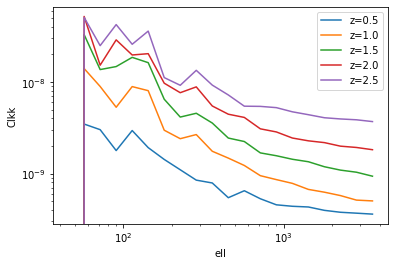

In [21]:
for i in range(5):
    loglog(ps_test[i][0], ps_test[i][1], label='z=%s'%(tomo_centers[i]))
xlabel('ell')
ylabel('Clkk')
legend()

In [24]:
peaks_test = [smoothed_conv_maps[i].peakCount(kappa_bin_edges[i]) for i in range(5)]

In [25]:
pdf_test = [smoothed_conv_maps[i].pdf(kappa_bin_edges[i]) for i in range(5)]

In [26]:
minima_test = [ConvergenceMap(data=-smoothed_conv_maps[i].data, 
                              angle=map_side_deg).peakCount(kappa_bin_edges[i]) for i in range(5)]

In [27]:
mf_test = [smoothed_conv_maps[i].minkowskiFunctionals(kappa_bin_edges[i]) for i in range(5)]

In [28]:
#moments_test = [smoothed_conv_maps[i].moments(kappa_bin_edges[i]) for i in range(5)]

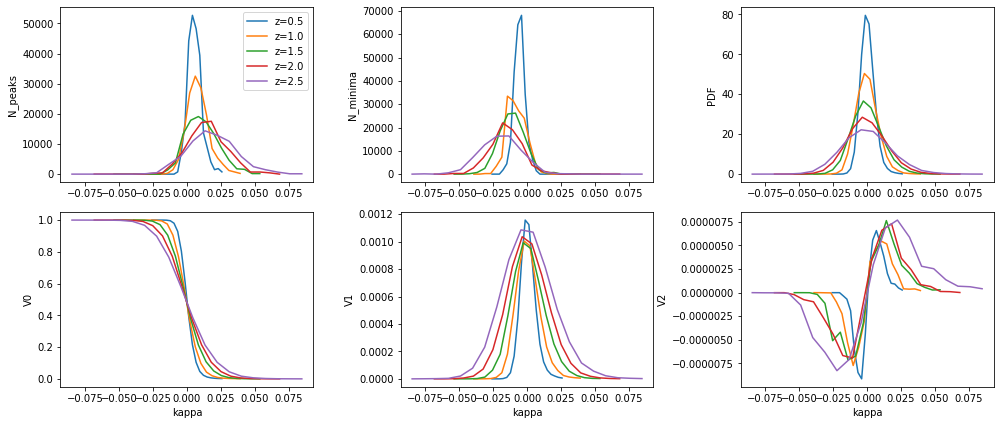

In [58]:
f,axes=subplots(2,3,figsize=(14,6))
for i in range(5):
    axes[0][0].plot(peaks_test[i][0], peaks_test[i][1], label='z=%s'%(tomo_centers[i]))
    axes[0][1].plot(minima_test[i][0], minima_test[i][1][::-1])## note need to flip the axis
    axes[0][2].plot(pdf_test[i][0], pdf_test[i][1])
    axes[1][0].plot(mf_test[i][0],mf_test[i][1])
    axes[1][1].plot(mf_test[i][0],mf_test[i][2])
    axes[1][2].plot(mf_test[i][0],mf_test[i][3])
axes[0][0].legend()
axes[1][0].set_xlabel('kappa')
axes[1][1].set_xlabel('kappa')
axes[1][2].set_xlabel('kappa')
axes[0][0].set_ylabel('N_peaks')
axes[0][1].set_ylabel('N_minima')
axes[0][2].set_ylabel('PDF')
axes[1][0].set_ylabel('V0')
axes[1][1].set_ylabel('V1')
axes[1][2].set_ylabel('V2')
plt.tight_layout()

### 6) turn this into a python code

In [30]:
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})

In [46]:
!pwd

/global/u1/j/jialiu/NGphotoz


In [31]:
## get the std for 5 z, theta_g = 1, 5, 10
Nbin=20
theta_g_arr = [1,5,10]
###### this cell takes long time to compute
# smoothed_conv_maps= [[conv_maps[i].smooth(theta_g*u.arcmin) for i in range(5)]
#                      for theta_g in theta_g_arr]
# sigma_kappa_arr = [[imap.std() for imap in maps] for maps in smoothed_conv_maps]
# savetxt('sigma_kappa.txt', sigma_kappa_arr, header='#rows=3 smoothing scales (1,5,10), cols=5 tomo bins')
# !git add sigma_kappa.txt; git commit -m 'add sigma_kappa.txt'; git push

sigma_kappa_arr = genfromtxt('sigma_kappa.txt')

print (array(sigma_kappa_arr).shape)
print ('sigma_kappa for 3 smoothing, 5 tomo bins:')

for isigma in sigma_kappa_arr:
    print (isigma)

(3, 5)
sigma_kappa for 3 smoothing, 5 tomo bins:
[ 0.01942  0.02415  0.03330  0.04502  0.06246]
[ 0.00543  0.00825  0.01131  0.01437  0.01782]
[ 0.00360  0.00586  0.00811  0.00995  0.01184]


In [32]:
#savetxt('ngal_tomo.txt', ngal_tomo, header='# ngal for 5 tomographic bins')
ngal_tomo = loadtxt('ngal_tomo.txt')
print (ngal_tomo)

[ 16.06516  12.82188  6.93196  3.51237  1.66494]


In [33]:
## galaxy noise, assuming z0_SRD, alpha_SRD = 0.11, 0.68, ngal_total=46
# ngal_tomo = array([16.0651584 , 12.82188281,  6.9319586 ,  3.5123717 ,  1.66494164])

## first set bin edges
sigma_bin_edges = linspace(-5,5,Nbin+1)

kappa_bin_edges = kron(sigma_kappa_arr,sigma_bin_edges).reshape(3,5,-1)
print (kappa_bin_edges.shape)
#print ('(kappa) bin edges for 3 smoothing, 5 tomo bins:\n', kappa_bin_edges)

(3, 5, 21)


In [34]:
# test_dir=/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/
!ls /global/cscratch1/sd/jialiu/desc-sprint-raytracing/
!ls /global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/
!ls /global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/00_a/*tomo1*fits

Cosmo_maps  Cov_maps  Nz  biased_maps  kappa
00_a  02_a  04_a  06_a	08_a  10_a  12_a  14_a	16_a  18_a  20_a  22_a	24_a
00_f  02_f  04_f  06_f	08_f  10_f  12_f  14_f	16_f  18_f  20_f  22_f	24_f
01_a  03_a  05_a  07_a	09_a  11_a  13_a  15_a	17_a  19_a  21_a  23_a	fid_a
01_f  03_f  05_f  07_f	09_f  11_f  13_f  15_f	17_f  19_f  21_f  23_f	fid_f
/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/00_a/kappa_LSST-SRD_tomo1_cone1.fits
/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/00_a/kappa_LSST-SRD_tomo1_cone2.fits
/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/00_a/kappa_LSST-SRD_tomo1_cone3.fits
/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/00_a/kappa_LSST-SRD_tomo1_cone4.fits
/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/00_a/kappa_LSST-SRD_tomo1_cone5.fits


In [35]:
cosmos = [ '%02d_%s'%(i, j) for i in range(25) for j in ['a','f']]
cosmos += ['fid_a', 'fid_f']
cosmo_dir = '/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/'
cosmo_fn_gen = lambda cosmo, tomo, cone: cosmo_dir+cosmo+'/kappa_LSST-SRD_tomo%i_cone%i.fits'%(tomo, cone)

### tomo runs from 1-5, cone run from 1-5, cosmo run from 0-24, 25 is the fiducial model

In [36]:
####### test file name geneartor: pass
# cosmo_fn_gen(cosmos[0], 2, 3)
# ! ls /global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/00_a/kappa_LSST-SRD_tomo2_cone3.fits

In [37]:
l_edges = logspace(log10(40),log10(4000),Nbin+1)

sigma_e=0.26
map_side_deg = 10*u.degree
map_pix = 7745
theta_g_arr = [1,5,10]

pixel_angular_side = map_side_deg / map_pix

sigma_pix_arr =[ (sigma_e / (pixel_angular_side * sqrt(ingal / u.arcmin**2))).decompose().value
                for ingal in ngal_tomo]

print (sigma_pix_arr)

## kappa_bin_edges.shape == (3,5,21)
def map_stats (cosmo, tomo, cone):
    '''for fits file fn, generate ps, peaks, minima, pdf, MFs
    fn: input file name, including full path
    tomo=1, 2,..5: int, for tomographic bins
    cone=1, 2,..5: int, for light cones'''
    fn = cosmo_fn_gen(cosmo, tomo, cone)
    imap = fits.open(fn)[0].data ## open the file
    ### add noise
    ### generate random see, such that it is the same for all cosmology
    ### but different for tomo and cone
    if cosmo[-1]=='a':
        iseed=int(cone*100+tomo)
    else: ##'f' starts with a different seed from the a cosmology
        iseed=int(1000+cone*100+tomo)
    seed(iseed)
    noise_map = np.random.normal(loc=0.0, scale=sigma_pix_arr[tomo-1], size=(map_pix, map_pix))
    kappa_map = ConvergenceMap(data=imap+noise_map, angle=map_side_deg)
    
    ### smooth the map
    smoothed_kappa_maps= [kappa_map.smooth(theta_g*u.arcmin) for theta_g in theta_g_arr]
    
    out=zeros(shape=(3, 11, Nbin)) 
    # 3 smoothing, 9 cols: ell, ps, kappa, peak, minima, pdf, v0, v1, v2
    ### compute stats
    ps_noiseless=ConvergenceMap(data=imap, angle=map_side_deg).powerSpectrum(l_edges)
    ps_unsmoothed=kappa_map.powerSpectrum(l_edges) ## power spectrum should be computed on unsmoothed maps
    
    s=0 ## smoothing scale counter
    for imap in smoothed_kappa_maps:
        kappa_bins = kappa_bin_edges[s][tomo-1] 
        ps=imap.powerSpectrum(l_edges)
        peak=imap.peakCount(kappa_bins)
        minima = ConvergenceMap(data=-imap.data, angle=map_side_deg).peakCount(kappa_bins)
        pdf=imap.pdf(kappa_bins)
        mfs=imap.minkowskiFunctionals(kappa_bins)
        out[s,0] = ps[0]
        out[s,1] = ps_noiseless[1]
        out[s,2] = ps_unsmoothed[1]
        out[s,3] = ps[1]
        out[s,4] = peak[0]
        out[s,5] = peak[1]
        out[s,6] = minima[1][::-1]
        out[s,7] = pdf[1]
        out[s,8] = mfs[1]
        out[s,9] = mfs[2]
        out[s,10] = mfs[3]
        s+=1
    return out

[0.8373384105183674, 0.9372762622559347, 1.2747221711708747, 1.7907843281194085, 2.601021919546927]


In [38]:
out=map_stats(cosmos[-1],4,5)

In [39]:
## A) 124 maps for the covariance matrix out of the 800+ I plan to do, 
## B) 10 maps per cosmology out of potentially 50, and 
## C) one map per n(z) case.

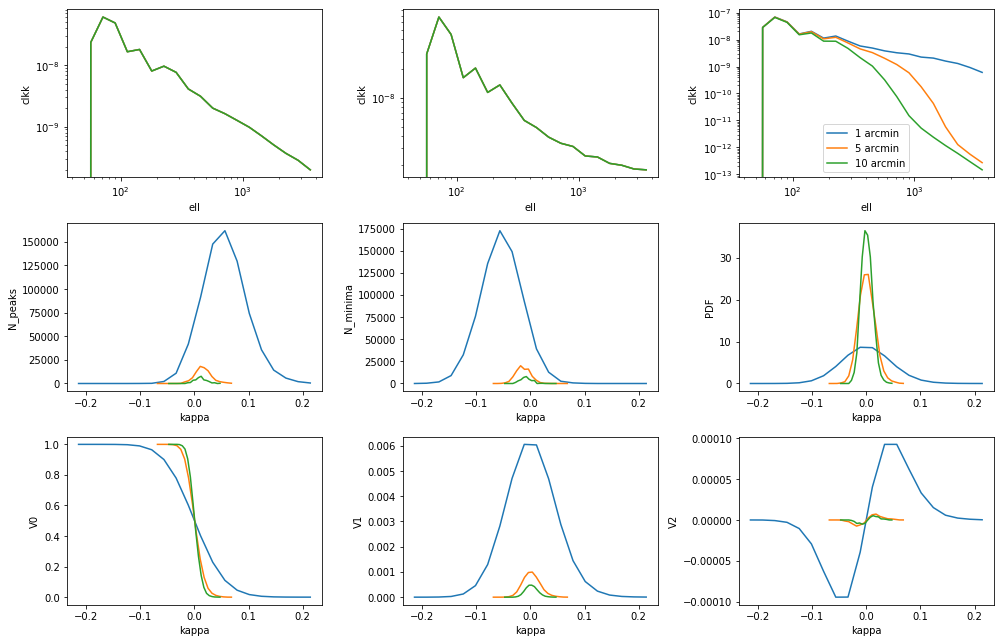

In [42]:
f,axes=subplots(3,3,figsize=(14,9))
for s in range(3):
    axes[0][0].loglog(out[s][0],out[s][1])
    axes[0][1].loglog(out[s][0],out[s][2])
    axes[0][2].loglog(out[s][0],out[s][3],label='%i arcmin'%(theta_g_arr[s]))
    axes[1][0].plot(out[s][4],out[s][5])
    axes[1][1].plot(out[s][4],out[s][6])
    axes[1][2].plot(out[s][4],out[s][7])
    axes[2][0].plot(out[s][4],out[s][8])
    axes[2][1].plot(out[s][4],out[s][9])
    axes[2][2].plot(out[s][4],out[s][10])
axes[0][2].legend()

axes[0][0].set_xlabel('ell')
axes[0][0].set_ylabel('clkk')
axes[0][1].set_xlabel('ell')
axes[0][1].set_ylabel('clkk')
axes[0][2].set_xlabel('ell')
axes[0][2].set_ylabel('clkk')

axes[1][0].set_xlabel('kappa')
axes[1][1].set_xlabel('kappa')
axes[1][2].set_xlabel('kappa')
axes[1][0].set_ylabel('N_peaks')
axes[1][1].set_ylabel('N_minima')
axes[1][2].set_ylabel('PDF')

axes[2][0].set_xlabel('kappa')
axes[2][1].set_xlabel('kappa')
axes[2][2].set_xlabel('kappa')
axes[2][0].set_ylabel('V0')
axes[2][1].set_ylabel('V1')
axes[2][2].set_ylabel('V2')
plt.tight_layout()

In [56]:
cosmo_tomo_cone_arr = [[cosmo, tomo, cone] 
                       for cosmo in cosmos 
                       for tomo in range(1,6)
                       for cone in range(1,6)]
print ( len(cosmo_tomo_cone_arr))

1300


In [57]:
out.shape

(3, 11, 20)

In [63]:
run map_stats.py

/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/00_a/kappa_LSST-SRD_tomo1_cone2.fits
/global/u1/j/jialiu/NGphotoz/NGphotoz_scratch/Cosmo_maps/00_a_tomo1_cone2_s1.npy does NOT exist; compute NG stats..
/global/u1/j/jialiu/NGphotoz/NGphotoz_scratch/Cosmo_maps/00_a_tomo1_cone2_s5.npy does NOT exist; compute NG stats..
/global/u1/j/jialiu/NGphotoz/NGphotoz_scratch/Cosmo_maps/00_a_tomo1_cone2_s10.npy does NOT exist; compute NG stats..
